# Portland Trail Blazers - Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 5 # Portland Trail Blazers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

### Let's drop the features that have lots of null values, as these won't be useful to our model:

In [4]:
df.drop([
    'urbanicity', 
    'isnextyear_buyer', 
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "education",
    "fill_out_form",
    "forward_records",
    "gender",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "posting_records",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "resale_atp",
    "resale_records",
    "source_tenure",
    "totalSpent",
    "tenure",
    "year"
]

# select 90% of the data for training
df_train = df.sample(frac=0.9, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df.drop(df_train.index).reset_index(drop=True)

# choose features for each train dataset
df_train = df_train[features]

# choose features for each train dataset
df_eval = df_eval[features]

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (9896, 21)
Unseen Data For Predictions: (1100, 21)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [ ]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "fill_out_form",
        "forward_records",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "posting_records",
        "recency",
        "renewedBeforeDays",
        "resale_atp",
        "resale_records",
        "source_tenure",
        "totalSpent"
    ]
)

In [7]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.9169,0.9609,0.9693,0.8162,0.8861,0.8215,0.8291,0.0860
8,NGBClassifier,0.9157,0.9597,0.9826,0.8070,0.8862,0.8203,0.8304,1.5430
0,Ada Boost Classifier,0.9156,0.9602,0.9655,0.8157,0.8842,0.8186,0.8259,0.2270
5,Light Gradient Boosting Machine,0.9146,0.9603,0.9409,0.8271,0.8802,0.8143,0.8185,0.0260
9,Extreme Gradient Boosting,0.9112,0.9600,0.9284,0.8269,0.8746,0.8062,0.8096,0.3640
7,Random Forest Classifier,0.9074,0.9571,0.9064,0.8312,0.8671,0.7963,0.7981,0.1400
3,Extra Trees Classifier,0.9010,0.9517,0.8883,0.8276,0.8568,0.7812,0.7825,0.1380
1,Decision Tree Classifier,0.8808,0.8663,0.8136,0.8265,0.8199,0.7308,0.7310,0.0110
6,Logistic Regression,0.8613,0.9186,0.8712,0.7367,0.7920,0.6905,0.7012,0.1300
4,K Neighbors Classifier,0.8485,0.9113,0.8504,0.7365,0.7893,0.6720,0.6764,0.0330


### The top model is performing well, so let's compare it against our unseen eval dataset:

In [8]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9242,0.9609,0.9659,0.8333,0.8947,0.8361,0.8416
1,0.9129,0.9573,0.9470,0.8197,0.8787,0.8113,0.8165
2,0.9040,0.9542,0.9659,0.7919,0.8703,0.7953,0.8052
3,0.9217,0.9589,0.9697,0.8258,0.8920,0.8312,0.8378
4,0.9028,0.9545,0.9545,0.7950,0.8675,0.7917,0.8000
5,0.9230,0.9694,0.9848,0.8202,0.8950,0.8350,0.8437
6,0.9343,0.9686,0.9886,0.8419,0.9094,0.8583,0.8652
7,0.9254,0.9730,0.9773,0.8296,0.8974,0.8394,0.8464
8,0.9115,0.9547,0.9659,0.8070,0.8793,0.8103,0.8185
9,0.9090,0.9577,0.9735,0.7981,0.8771,0.8060,0.8160


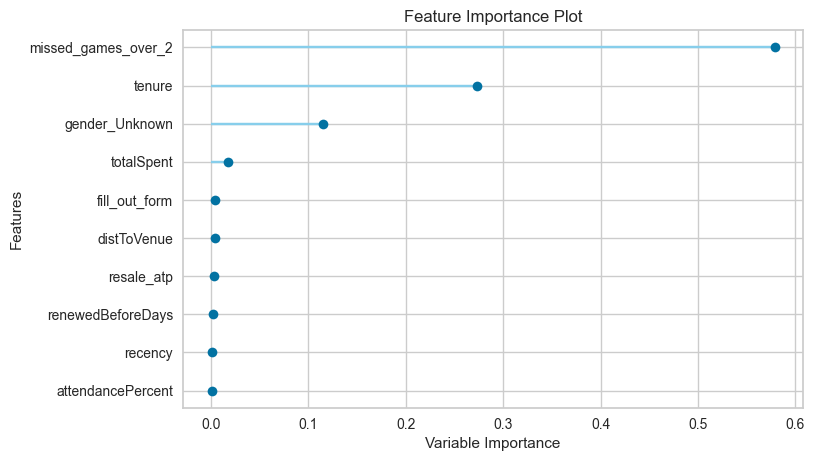

In [9]:
plot_model(best_model, plot='feature')

In [ ]:
plot_model(best_model, plot='confusion_matrix')

## Results

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?